<img src="files/Northwind_ERD_updated.png">

## Question 1

**Research question 1:** Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In [1]:
import pandas as pd
import sqlite3
import numpy as np
from functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
cursor.execute('select name from sqlite_master where type ="table"').fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [4]:
df = get_table(table='OrderDetail')

In [5]:
inspect_dataframe(df)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


None

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [6]:
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [7]:
# cur.execute("""SELECT * from OrderDetail""")

# df = pd.DataFrame(cur.fetchall())
# df.columns = [x[0] for x in cur.description]

# print(len(df))
# df.head()

In [8]:
discount_rates = set(df.Discount.values)

In [9]:
# avg_order_size = []
# for d in discount_rates:
#     mu = df[df['Discount'] == d]['Quantity'].mean()
#     avg_order_size.append(mu)
    
# avg_order_size

In [10]:
avg_discount_order_size = {}

for d in discount_rates: 
    avg_discount_order_size[d] = df[df['Discount'] == d]['Quantity'].mean()
    
avg_discount_order_size

{0.0: 21.715261958997722,
 0.25: 28.24025974025974,
 0.2: 27.024844720496894,
 0.05: 28.01081081081081,
 0.15: 28.38216560509554,
 0.1: 25.23699421965318,
 0.03: 1.6666666666666667,
 0.06: 2.0,
 0.01: 2.0,
 0.04: 1.0,
 0.02: 2.0}

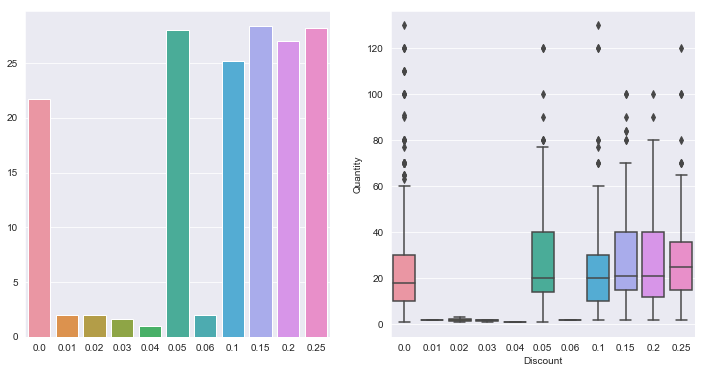

In [11]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

sns.barplot(x=list(avg_discount_order_size.keys()), y=list(avg_discount_order_size.values()), ax=ax1)
sns.boxplot(x=df.Discount, y=df.Quantity, data=df, ax=ax2)
plt.show()

**Record initial observations**

In [12]:
# df.ProductId.nunique()

In [13]:
# df.OrderId.nunique()

In [14]:
# len(df.OrderId)

**Does discount have an effect on order size? Break data into 2 groups: discount and no-discount**

In [15]:
no_d = np.array(df[df['Discount'] == 0.0]['Quantity'])
d = np.array(df[df['Discount'] != 0.0]['Quantity'])

In [16]:
compare_2(no_d,d)

The size of group1 is: 1317  	  The size of group2 is 838
The mean of group1 is: 21.715261958997722 	  The mean of group2 is: 27.10978520286396
The std of group1 is: 17.500845477669806 	  The std of group2 is: 20.759042075141373


* record some observations

visually inspect

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


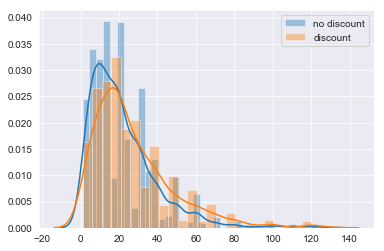

In [17]:
sns.distplot(no_d, label='no discount')
sns.distplot(d, label='discount')
plt.legend()

We've given it a good look, reiterate observations and make some hypotheses

**Null Hypothesis (H0): There is no relationship between discount and quantity ordered**

**Alternative Hypothesis (Ha): There is a positive relationship between discount and quantity ordered - a discount is likely to result in a larger order**

To ensure we have a stisitcally significant effect we'll get for a 95% level of confidence, and set **alpha to .05**

In [18]:
alpha=.05

In order to accept or reject H0 we will conduct a statistical test to see if the quantities ordered with a discount are statistically significantly greater than our baseline orders, or, orders with no discount. 

We can test our hypothesis with a one-sided t-test. Both of our groups of data are independent of one another, that is to say that quantity ordered per order in one group should not be affected by quantity ordered in the other. Therefore we will do an independent t-test with. 

But, first we must check our assumptions of normality for each group to determine if we need to sample. We'll do this with the shapiro-wilke test for normality. 

In [19]:
test_normality(d)
test_normality(no_d)

p = 6.88120409395894e-26 	 Therefore the data is not normal
p = 3.803856556577728e-34 	 Therefore the data is not normal


False

It looks like our data are not normally distributed. We'll need to sample from them to see if we can arrive at a more normal distribution to run our tests on. Let's draw those samples and test for normality again. 

In [20]:
no_discount_sample = random_sample(no_d)
discount_sample = random_sample(d)

test_normality(no_discount_sample)
test_normality(discount_sample)

p = 0.17676477134227753 	 Therefore the data is normal
p = 0.33313870429992676 	 Therefore the data is normal


True

Awesome, it looks like the Central Limit Theorem wins again! By drawing a series of random samples and obtaining their means we have identified a more normally distributed set of data. We can now move forward and check our variance assumption next, but first let's get a quick visual representation of our data now.   

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


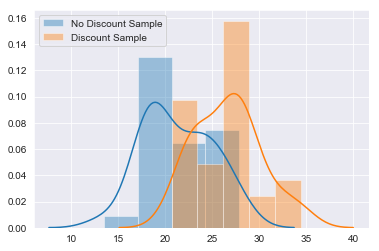

In [21]:
sns.distplot(no_discount_sample, label='No Discount Sample')
sns.distplot(discount_sample, label='Discount Sample')
plt.legend()

Now let's check to see if we have equal variance among our sample groups, that will determine which type of t-test we should perform. We'll do this using Levene's test for equal variance. 

In [22]:
test_variance(no_discount_sample, discount_sample)

p = 0.45557195862775246 	 Therefore the data has equal variances


True

Our samples have sufficiently equal variance, we'll therefore use the Student's T-Test to compare the two groups. We'll be looking for a p-value of less than .05 if we want to reject our null hypothesis.  

In [23]:
p = stats.ttest_ind(no_discount_sample, discount_sample, axis=0, equal_var=True)[1]

check_null_hypothesis(p,alpha=alpha)

With a p-value of 2.702034573181609e-07, which is less than 0.05 we can reject the H0 and accept Ha


False

It appears that for now we can reject the null hypothesis and conclude that there is a statistically significant and positive difference between quantities ordered with a discount than without a discount. There is a very low probability of a type 1 error, meaning that our results are due to random chance and that there is in fact not a positive effect on order size with a discount. 

In order to ensure that our results are as accurate as possible we can check the effect and power of our conclusions.

In [24]:
# check effect size with cohen's d
discount_effect = cohen_d(no_discount_sample, discount_sample)
discount_effect

1.5282048629314349

This is a fairly large effect size, reinforcing our conclusion to reject H0. We can use effect size to check the statistical power of our results as well. Here we will be looking for a power larger than .8, which tells us that our number of observations were large enough to draw our conclusions from at this level of alpha. 

In [25]:
from statsmodels.stats.power import TTestIndPower
power = TTestIndPower()

In [26]:
power.solve_power(effect_size=discount_effect, nobs1=len(discount_sample), alpha=alpha, alternative='larger')

0.999999998377637

We have the power! It looks like our sample size is sufficiently big enough to detect an effect given our degree of confidence as set by alpha. 

With this, we can again affirm our conclusion to reject H0 and determine that discounts do indeed have a positive effect on quantity ordered. 

We can now move on to answering the second part of our question, which discount rates in fact have and effect on quantities ordered? First we can check to see if there is a significant difference among rates by conducting an ANOVA analysis. 

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'Quantity ~ C(Discount)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(Discount),21258.403604,10.0,6.011811,4.704231e-09
Residual,758141.232591,2144.0,NaN,NaN


With a very low p-value (4.7 e-09) we can conclude that there is in fact a difference among discount rates. Let's check the levels of significance for each category of discount. 

In [28]:
lm.pvalues

Intercept              6.746766e-281
C(Discount)[T.0.01]     2.947414e-01
C(Discount)[T.0.02]     1.385988e-01
C(Discount)[T.0.03]     6.524250e-02
C(Discount)[T.0.04]     2.709368e-01
C(Discount)[T.0.05]     2.095341e-05
C(Discount)[T.0.06]     2.947414e-01
C(Discount)[T.0.1]      2.065861e-02
C(Discount)[T.0.15]     2.789428e-05
C(Discount)[T.0.2]      7.326710e-04
C(Discount)[T.0.25]     4.781032e-05
dtype: float64

Recalling from our earlier value counts that there were very few observations for rates from 0.01-0.04, and only one for 0.06, we can disregard those as we do not have a large enough sample to determine statistical significance.

That leaves us with .05, .1, .15, .2 and .25. each of which appear to have a low enough p-value to suggest further analysis. 

To do this we will do post hoc t-tests with the Bonferroni correction. We will sample each group as before and compare them to the control sample (no discount). 

First, lets establish our new level of alpha by applying Bonferroni. 

In [29]:
b_alpha = bonferroni_alpha(obs=5, alpha=alpha)
b_alpha

0.01

Now we will need to create sample for each of our discount levels and test for normality and variance

In [30]:
five_sample = random_sample(df[df['Discount'] == .05]['Quantity'])
ten_sample = random_sample(df[df['Discount'] == .1]['Quantity'])
fifteen_sample = random_sample(df[df['Discount'] == .15]['Quantity'])
twenty_sample = random_sample(df[df['Discount'] == .2]['Quantity'])
twentyfive_sample = random_sample(df[df['Discount'] == .25]['Quantity'])

discount_samples = {'5% Discount':five_sample, 
                    '10% Discount':ten_sample, 
                    '15% Discount':fifteen_sample, 
                    '20% Discount':twenty_sample, 
                    '25% Discount':twentyfive_sample}
# sample_names = ['5% Discount', '10% Discount', '15% Discount', '20% Discount', '25% Discount']

# for s,n in samples,sample_names:
#     print(n)
#     test_normality(s)
for s in discount_samples:
    print(f'{s}: {test_normality(discount_samples[s])}')
    print(f'{s}: {test_variance(discount_samples[s], no_discount_sample)}\n')

p = 0.41059958934783936 	 Therefore the data is normal
5% Discount: True
p = 0.652406050233501 	 Therefore the data has equal variances
5% Discount: True

p = 0.8815193176269531 	 Therefore the data is normal
10% Discount: True
p = 0.9970978349416025 	 Therefore the data has equal variances
10% Discount: True

p = 0.3587958514690399 	 Therefore the data is normal
15% Discount: True
p = 0.5354049688270899 	 Therefore the data has equal variances
15% Discount: True

p = 0.31754830479621887 	 Therefore the data is normal
20% Discount: True
p = 0.8256956675283352 	 Therefore the data has equal variances
20% Discount: True

p = 0.7198901772499084 	 Therefore the data is normal
25% Discount: True
p = 0.4694799811225695 	 Therefore the data has equal variances
25% Discount: True



By sampling for each discount level we've satisfied our normality and variance assumptions, now we can conduct t-tests with our new confidence level set by the Bonferroni Correction, and check for effect sizes and power levels as well. 

In [31]:
for s in discount_samples:
    p = stats.ttest_ind(no_discount_sample, discount_samples[s], axis=0, equal_var=True)[1]
    print(f'{s}: {check_null_hypothesis(p, alpha=b_alpha)}')

With a p-value of 9.217604953337244e-12, which is less than 0.01 we can reject the H0 and accept Ha
5% Discount: False
With a p-value of 0.004004228162288465, which is less than 0.01 we can reject the H0 and accept Ha
10% Discount: False
With a p-value of 4.0796928624062356e-11, which is less than 0.01 we can reject the H0 and accept Ha
15% Discount: False
With a p-value of 2.94807415951583e-06, which is less than 0.01 we can reject the H0 and accept Ha
20% Discount: False
With a p-value of 2.044199082736009e-09, which is less than 0.01 we can reject the H0 and accept Ha
25% Discount: False


In [32]:
effect = {}
for s in discount_samples:
    effect[s] = cohen_d(no_discount_sample,discount_samples[s])
effect

{'5% Discount': 2.230148246759387,
 '10% Discount': 0.7871431047925743,
 '15% Discount': 2.128566433732904,
 '20% Discount': 1.3595770938960852,
 '25% Discount': 1.862759213743562}

In [33]:
for e in effect: 
    print(f'{e}: {power.solve_power(effect_size=effect[e], nobs1=30, alpha=b_alpha)}')

5% Discount: 1.0
10% Discount: 0.6500257340658221
15% Discount: 1.0
20% Discount: 0.9944018276283494
25% Discount: 1.0


**Conclusions for question 1**

## Question 2

**Research question 2:** Do different employees sell a statistically significantly different quantity of items per order? If so, which ones? 

To get this we'll combine two tables from our dataset, the 'Order' table and the 'OrderDetail' table, and extract the values we need to make our assessment. 

In [34]:
OrderDetail = get_table(table = 'OrderDetail')
OrderDetail.head ()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [35]:
cur.execute("""SELECT Id, EmployeeId
               FROM 'Order' """)

Order = pd.DataFrame(cur.fetchall())
Order.columns = [x[0] for x in cur.description]

print(len(Order))
Order.head()

830


,Id,EmployeeId
0,10248,5
1,10249,6
2,10250,4
3,10251,3
4,10252,4


We can see that 'OrderId' and 'Id' have the same values, so we can join the 'EmployeeId' information from 'Order' to our 'OrderDetail' table so we know which employee made which sale. 

Although all we really need is the discount information at this point, we'll keep all the values from the combined table for now in case we want to do further analysis on those later. 

In [36]:
df2 = pd.merge(OrderDetail, Order, left_on='OrderId', right_on='Id', how='left')
inspect_dataframe(df2)

,Id_x,OrderId,ProductId,UnitPrice,Quantity,Discount,Id_y,EmployeeId
0,10248/11,10248,11,14.0,12,0.0,10248,5
1,10248/42,10248,42,9.8,10,0.0,10248,5
2,10248/72,10248,72,34.8,5,0.0,10248,5
3,10249/14,10249,14,18.6,9,0.0,10249,6
4,10249/51,10249,51,42.4,40,0.0,10249,6


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2154
Data columns (total 8 columns):
Id_x          2155 non-null object
OrderId       2155 non-null int64
ProductId     2155 non-null int64
UnitPrice     2155 non-null float64
Quantity      2155 non-null int64
Discount      2155 non-null float64
Id_y          2155 non-null int64
EmployeeId    2155 non-null int64
dtypes: float64(2), int64(5), object(1)
memory usage: 151.5+ KB


None

,OrderId,ProductId,UnitPrice,Quantity,Discount,Id_y,EmployeeId
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,10659.375870,4.333179
std,241.378032,22.159019,29.827418,19.022047,0.083450,241.378032,2.490351
min,10248.000000,1.000000,2.000000,1.000000,0.000000,10248.000000,1.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,10451.000000,2.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,10657.000000,4.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,10862.500000,7.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,11077.000000,9.000000


**Observations:** We are still working with 2155 unique combinations of 'OrderId' and 'ProductId', of which there are no null values. Quantity does seem to have a few high outliers, but the mean and median are fairly close so we can leave them for now and come back to them if we see problematic skewness later. 

Let's also get a rough idea of what our employee sales look like. We can make a pivot table to see how many sales they have made, the total quantity of items sold, and the average quantity per order. 

In [37]:
df2_pivot = pd.pivot_table(df2, values='Quantity', 
                           index= 'EmployeeId', 
                           aggfunc= [np.count_nonzero, np.sum, np.mean, np.std])
df2_pivot

,count_nonzero,sum,mean,std
,Quantity,Quantity,Quantity,Quantity
EmployeeId,,,,
1,345,7812,22.643478,19.658357
2,241,6055,25.124481,21.164068
3,321,7852,24.461059,18.396651
4,420,9798,23.328571,18.105542
5,117,3036,25.948718,20.755907
6,168,3527,20.994048,16.694686
7,176,4654,26.443182,21.185093
8,260,5913,22.742308,17.480462


We can check quickly to make sure that we have all of our rows accounted for (and not over counted) by summing the count column. 

In [38]:
df2_pivot['count_nonzero']['Quantity'].sum()

2155

Looks like we're in good shape, all rows are accounted for.
**Other observations:**
* There appears to be some variance in number of sales made by each employee, which also effect total quantity sold
* Although some employees have made many more sales than others, the average quantity sold appears fairly equal

Let's see how it looks visually

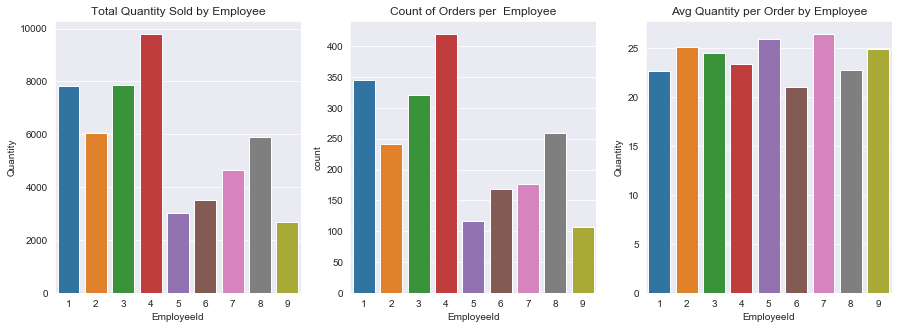

In [115]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

a = sns.barplot(x=df2_pivot.index, y=df2_pivot['sum']['Quantity'], ax=ax1)
a.axes.set_title('Total Quantity Sold by Employee')

b = sns.countplot(x='EmployeeId', data=df2, ax=ax2)
b.axes.set_title('Count of Orders per Employee')

c = sns.barplot(x=df2_pivot.index, y=df2_pivot['mean']['Quantity'], ax=ax3)
c.axes.set_title('Avg Quantity per Order by Employee');

**Observations:** 
* Very interestingly total quantity ordered and number of orders are very similar
* In naturally follows that that average order size is very similar as well 

To check and see if there truly is any variability between quantity per order per employee we can do an ANOVA test. For this test:
1. Our **null hypothesis (H0)** will be that there is no difference is order sizes for each employee
2. Our **alternative hypothesis (Ha)** will then be that there is some variance in quantity ordered per employee per order
3. We will look for a p-value that gives us a 95% confidence level of avoiding a type 1 error, and therefor set alpha to .05

In [40]:
formula = 'Quantity ~ C(EmployeeId)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(EmployeeId),4643.183282,8.0,1.607646,0.11745
Residual,774756.452913,2146.0,NaN,NaN


**Conclusion:** With a p-value above our level of alpha (0.117 > .05) we **fail to reject** the null hypothesis. We cannot conclude at this time that any employee sells a statistically significantly different quantity of items per sale. 

**Next Steps:** We now know from question 1 that discounts do tend to result in a larger quantity sold per order with significant effect, and we now know that while some employees do sell a much larger overall quantity, they all sell about the same quantity per order itself. 

A question that follows is: "Why do some employees sell more than others?" 

One hypothesis is that some employees may be more likely to use a discount than others. We'll explore that in our next question. 

## Question 3 

**Research question 3:** Do different employees use discounts at a rate that is statistically significantly different than the overall average rate of discount use? If so, which employees are more likely to employ a discount? Do those employees sell a larger overall quantity? 

In [41]:
formula = 'Discount ~ C(EmployeeId)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(EmployeeId),0.16041,8.0,2.899611,0.003232
Residual,14.83993,2146.0,NaN,NaN


In [42]:
# Create a new column called y_discount where the value is 1
# if Discount is greater than 0.0 and 0 if not
df2['y_discount'] = np.where(df2['Discount'] > 0.0, 1, 0)
df2.head()

,Id_x,OrderId,ProductId,UnitPrice,Quantity,Discount,Id_y,EmployeeId,y_discount
0,10248/11,10248,11,14.0,12,0.0,10248,5,0
1,10248/42,10248,42,9.8,10,0.0,10248,5,0
2,10248/72,10248,72,34.8,5,0.0,10248,5,0
3,10249/14,10249,14,18.6,9,0.0,10249,6,0
4,10249/51,10249,51,42.4,40,0.0,10249,6,0


In [43]:
df2.y_discount.value_counts()

0    1317
1     838
Name: y_discount, dtype: int64

In [44]:
formula = 'y_discount ~ C(EmployeeId)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(EmployeeId),6.241641,8.0,3.309646,0.000914
Residual,505.891073,2146.0,NaN,NaN


p = 0.23684264719486237 	 Therefore the data is normal


/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


True

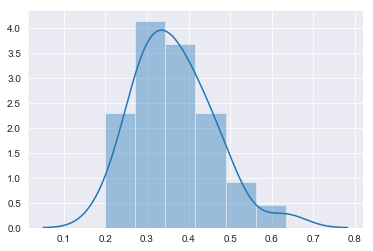

In [45]:
pop_sample = random_sample(df2.y_discount)
sns.distplot(pop_sample)
test_normality(pop_sample)

In [120]:
xu = mean(pop_sample)
print(f'{xu}')

0.36444444444444457


In [125]:
employees = list(range(1,10))
discount_usage = {}
for e in employees:
    discount_usage[e] = round(df2[df2['EmployeeId'] == e]['y_discount'].mean(), 3)
    print(f'Employee {e} uses a discount {discount_usage[e]}% of the time.')

Employee 1 uses a discount 0.391% of the time.
Employee 2 uses a discount 0.315% of the time.
Employee 3 uses a discount 0.324% of the time.
Employee 4 uses a discount 0.405% of the time.
Employee 5 uses a discount 0.504% of the time.
Employee 6 uses a discount 0.411% of the time.
Employee 7 uses a discount 0.477% of the time.
Employee 8 uses a discount 0.362% of the time.
Employee 9 uses a discount 0.439% of the time.


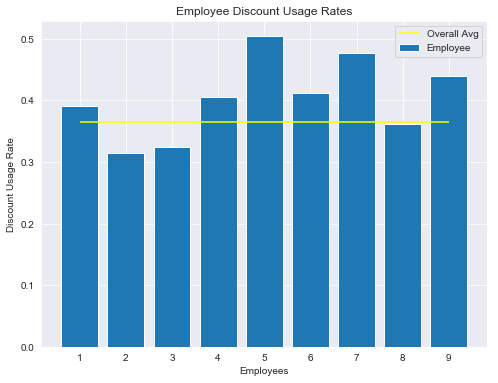

In [149]:
plt.figure(figsize=(8,6))
plt.bar(x=employees, height=discount_usage.values(), label='Employee')
plt.hlines(y=xu, xmin=1, xmax=9, label='Overall Avg', colors='yellow')
plt.xticks(ticks=employees)
plt.xlabel('Employees')
plt.ylabel('Discount Usage Rate')
plt.title('Employee Discount Usage Rates')
plt.legend();

In [151]:
emp_samples = {}
for e in employees:
    emp_samples[e] = random_sample(df2[df2['EmployeeId'] == e]['y_discount'])

for k in emp_samples:
    print(f'Employee {k}: {test_normality(emp_samples[k])}')
    print(f'Employee {k}: {test_variance(pop_sample, emp_samples[k])}\n')

p = 0.041698042303323746 	 Therefore the data is not normal
Employee 1: False
p = 0.6214357891041357 	 Therefore the data has equal variances
Employee 1: True

p = 0.1495928019285202 	 Therefore the data is normal
Employee 2: True
p = 1.0 	 Therefore the data has equal variances
Employee 2: True

p = 0.1588650494813919 	 Therefore the data is normal
Employee 3: True
p = 0.9362152370261434 	 Therefore the data has equal variances
Employee 3: True

p = 0.10414385050535202 	 Therefore the data is normal
Employee 4: True
p = 0.5517350155489746 	 Therefore the data has equal variances
Employee 4: True

p = 0.11839097738265991 	 Therefore the data is normal
Employee 5: True
p = 0.946162349645181 	 Therefore the data has equal variances
Employee 5: True

p = 0.16019822657108307 	 Therefore the data is normal
Employee 6: True
p = 0.8419410239992972 	 Therefore the data has equal variances
Employee 6: True

p = 0.3153058886528015 	 Therefore the data is normal
Employee 7: True
p = 0.49958720743

In [153]:
emp_discount_sample_df = pd.DataFrame.from_dict(emp_samples)
emp_discount_sample_df.head()

,1,2,3,4,5,6,7,8,9
0,0.566667,0.300000,0.300000,0.333333,0.433333,0.466667,0.433333,0.400000,0.366667
1,0.366667,0.233333,0.433333,0.533333,0.500000,0.500000,0.366667,0.400000,0.433333
2,0.400000,0.366667,0.200000,0.366667,0.466667,0.466667,0.566667,0.166667,0.466667
3,0.400000,0.466667,0.233333,0.366667,0.633333,0.266667,0.433333,0.400000,0.600000
4,0.366667,0.400000,0.366667,0.333333,0.533333,0.466667,0.600000,0.333333,0.433333


In [157]:
def get_distplots(df, comparison, cols=1):
    rows = math.ceil(len(df.columns)/cols)
    figwidth = 5 * cols
    figheight = 4 * rows
    
    fig, ax = plt.subplots(nrows = rows,
                           ncols = cols,
                           figsize = (figwidth, figheight))
    
    ax = ax.ravel()
    
    for i, column in enumerate(df.columns):
        sns.distplot(df[column], ax=ax[i], label='Emp Sample')
        sns.distplot(comparison, ax=ax[i], label='Pop Sample')
        
    
    plt.legend()
    plt.show()
    
    

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


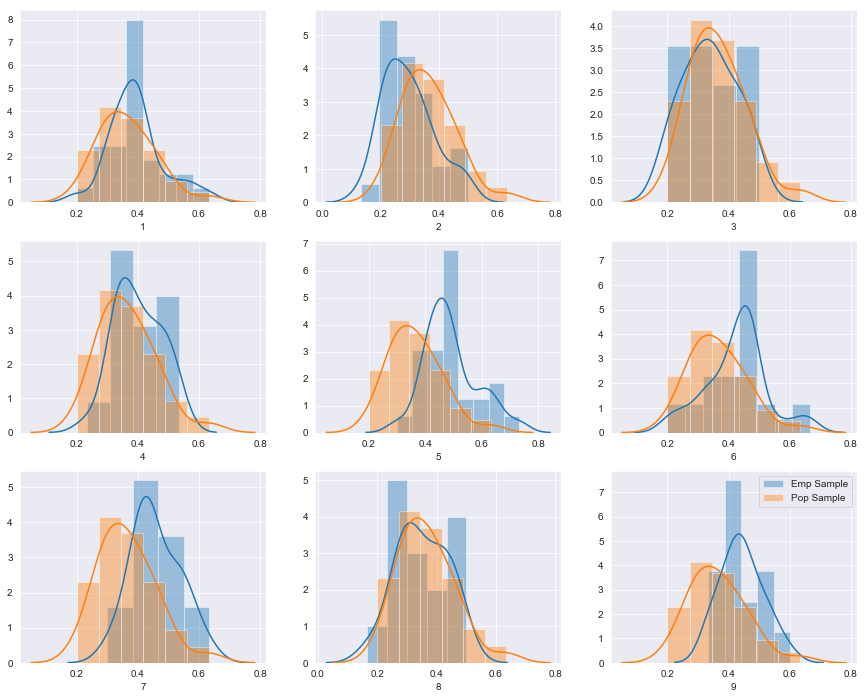

In [158]:
get_distplots(emp_discount_sample_df, pop_sample, cols=3)

In [169]:
employee_bonferroni = round(bonferroni_alpha(obs=9),4)
high_discount_employees = []
for k in emp_samples:
    p = stats.ttest_1samp(emp_samples[k], xu)[1]
    results = check_null_hypothesis(p, alpha=employee_bonferroni)
    print(f'Employee {k}: {results}\n')
    if results == False:
        high_discount_employees.append(k)
print(f'Employees {high_discount_employees} use discounts at a higher rate')

With a p-value of 0.07870871738716408, which is greater than 0.0056, at this time we fail to reject the H0
Employee 1: True

With a p-value of 0.00022444279174810037, which is less than 0.0056 we can reject the H0 and accept Ha
Employee 2: False

With a p-value of 0.1225843041028568, which is greater than 0.0056, at this time we fail to reject the H0
Employee 3: True

With a p-value of 0.01373785099829609, which is greater than 0.0056, at this time we fail to reject the H0
Employee 4: True

With a p-value of 6.88303608068519e-08, which is less than 0.0056 we can reject the H0 and accept Ha
Employee 5: False

With a p-value of 0.002942606161916561, which is less than 0.0056 we can reject the H0 and accept Ha
Employee 6: False

With a p-value of 4.093632968670231e-07, which is less than 0.0056 we can reject the H0 and accept Ha
Employee 7: False

With a p-value of 0.40083840293498163, which is greater than 0.0056, at this time we fail to reject the H0
Employee 8: True

With a p-value of 

In [170]:
emp_discount_effects = {}
for e in high_discount_employees:
    emp_discount_effects[e] = cohen_d(emp_samples[e], pop_sample)
emp_discount_effects

{2: 0.7690153544530938,
 5: 1.354240630029073,
 6: 0.6343034703241425,
 7: 1.112418706670321,
 9: 0.9824696073873851}

In [173]:
discount_powers = {}
for e in emp_discount_effects:
    discount_powers[e] = power.solve_power(effect_size=e, nobs1=30, alpha=employee_bonferroni)

discount_powers

{2: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 9: 1.0}

In [174]:
df2_pivot

,count_nonzero,sum,mean,std
,Quantity,Quantity,Quantity,Quantity
EmployeeId,,,,
1,345,7812,22.643478,19.658357
2,241,6055,25.124481,21.164068
3,321,7852,24.461059,18.396651
4,420,9798,23.328571,18.105542
5,117,3036,25.948718,20.755907
6,168,3527,20.994048,16.694686
7,176,4654,26.443182,21.185093
8,260,5913,22.742308,17.480462


## Question 3 

In [ ]:
Potential questions:

Which employee sells the most by quantity?
Which employee sells the most by revenue?
Which employee uses discounts the most?
Do discounts have greater effects on some products than others?
Does unit price have an effect on order size or discount size?

In [91]:
test_table = pd.pivot_table(df2, values='Quantity', index='EmployeeId', columns='ProductId', fill_value=0, aggfunc=np.sum)

In [93]:
test_table

ProductId,1,2,3,4,5,6,7,8,9,10,...,68,69,70,71,72,73,74,75,76,77
EmployeeId,,,,,,,,,,,,,,,,,,,,,
1,80,231,68,6,65,93,62,58,0,265,...,149,152,105,303,84,14,16,218,230,134
2,90,70,0,56,0,82,135,70,16,76,...,25,161,94,24,34,0,55,90,70,73
3,125,91,80,20,0,50,60,0,26,184,...,105,64,87,160,173,50,34,175,185,17
4,247,294,26,225,32,26,156,104,0,54,...,135,75,244,202,105,90,65,181,87,245
5,55,56,0,12,0,0,45,0,0,26,...,40,10,0,76,184,0,21,28,40,50
6,96,110,20,6,4,0,23,0,0,52,...,0,91,36,81,64,35,50,129,55,63
7,38,107,30,68,150,0,6,10,3,16,...,197,102,99,85,80,0,0,36,34,62
8,62,68,30,60,47,0,276,60,0,51,...,148,29,101,68,74,104,20,188,207,94
9,35,30,74,0,0,50,0,70,50,18,...,0,30,51,58,8,0,36,110,73,53


In [97]:
df2.ProductId.value_counts()

59    54
31    51
24    51
60    51
56    50
62    48
41    47
75    46
2     44
16    43
71    42
40    41
13    40
70    39
76    39
51    39
21    39
72    38
11    38
77    38
1     38
19    37
17    37
54    36
35    36
68    34
55    33
28    33
10    33
29    32
      ..
38    24
57    23
14    22
49    21
47    21
23    20
4     20
34    19
58    18
25    18
63    17
20    16
32    15
12    14
73    14
45    14
22    14
8     13
74    13
3     12
6     12
67    10
50    10
5     10
27     9
66     8
48     6
15     6
37     6
9      5
Name: ProductId, Length: 77, dtype: int64

In [103]:
test_3 = df2[df['ProductId'] == 11]
test_3

,Id_x,OrderId,ProductId,UnitPrice,Quantity,Discount,Id_y,EmployeeId,y_discount
0,10248/11,10248,11,14.0,12,0.00,10248,5,0
129,10296/11,10296,11,16.8,12,0.00,10296,6,0
210,10327/11,10327,11,16.8,50,0.20,10327,2,1
280,10353/11,10353,11,16.8,12,0.20,10353,7,1
313,10365/11,10365,11,16.8,24,0.00,10365,3,0
425,10407/11,10407,11,16.8,30,0.00,10407,2,0
491,10434/11,10434,11,16.8,6,0.00,10434,3,0
513,10442/11,10442,11,16.8,30,0.00,10442,3,0
516,10443/11,10443,11,16.8,6,0.20,10443,8,1
582,10466/11,10466,11,16.8,10,0.00,10466,4,0


In [104]:
21*.75

15.75

In [101]:
Products = get_table(table='Product')
Products[Products['Id'] == 11]

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
10,11,Queso Cabrales,5,4,1 kg pkg.,21.0,22,30,30,0
